In [1]:
import os
import numpy as np
import keras
from keras.engine import  Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau

In [2]:
print(keras.__version__)

2.4.3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [4]:
# data are in dataset folder in zipped format
!ls "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/"

fer2013.csv  PrivateTest.zip  PublicTest.zip  Training.zip


In [5]:
!ls 

drive  sample_data


In [6]:
# This creates a temporary folder in drive root folder, so it will have to be reloaded again when required after terminating the session
# Permanent data are stored in dataset in zipped format
# This copies the zipped file and store in root of google drive temporarily
! rm -rf Training; mkdir Training
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/Training.zip" -d Training

! rm -rf Validation; mkdir Validation
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/PublicTest.zip" -d Validation

! rm -rf Test; mkdir Test
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/PrivateTest.zip" -d Test

In [7]:
!ls

drive  sample_data  Test  Training  Validation


In [8]:
!ls -l Training/

total 808
drwxr-xr-x 2 root root 122880 Oct 11 05:04 Angry
drwxr-xr-x 2 root root  16384 Oct 11 05:04 Disgust
drwxr-xr-x 2 root root 122880 Oct 11 05:04 Fear
drwxr-xr-x 2 root root 217088 Oct 11 05:04 Happy
drwxr-xr-x 2 root root 135168 Oct 11 05:04 Neutral
drwxr-xr-x 2 root root 135168 Oct 11 05:04 Sad
drwxr-xr-x 2 root root  77824 Oct 11 05:04 Surprise


In [9]:
# Counting the images in each training data categories
%%bash
root='Training/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 3995
Disgust: 436
Fear: 4097
Happy: 7215
Neutral: 4965
Sad: 4830
Surprise: 3171


In [10]:
%%bash
root='Validation/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 467
Disgust: 56
Fear: 496
Happy: 895
Neutral: 607
Sad: 653
Surprise: 415


In [11]:
%%bash
root='Test/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 491
Disgust: 55
Fear: 528
Happy: 879
Neutral: 626
Sad: 594
Surprise: 416


In [12]:
train_dir = "Training/"
validation_dir = "Validation/"
test_dir = "Test/"

## All data are ready

In [30]:
# Setting image height and width
img_height = 224
img_width = 224

In [13]:
conv_base = VGG16(weights="imagenet",
                  include_top=False,
                  input_shape=(img_height, img_width, 3)
                  )

58892288/58889256 [==============================] - 0s 0us/step


In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
print("Number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("Number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

Number of trainable weights before freezing the conv base: 26


In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [37]:
from keras.layers import GlobalAveragePooling2D
DROP_OUT_RATE = 0.5
EPOCHS = 30
last_layer = conv_base.output

x = GlobalAveragePooling2D(name='global_avg_pool_1')(last_layer)
x = Dropout(DROP_OUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc1')(x)
out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(conv_base.input, out)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [39]:
# Image Data Generator setup
train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=90,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = 50,
    shuffle = True,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (img_height, img_width),
    batch_size = 50,
    class_mode = 'categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = 50,
    class_mode = 'categorical'
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [40]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


In [53]:
def class_weight_computer():
  """
    Training Data categories and number of samples in them
    Angry: 3995
    Disgust: 436
    Fear: 4097
    Happy: 7215
    Neutral: 4965
    Sad: 4830
    Surprise: 3171
  """
  samples_per_label = [3995, 436, 4097, 7215, 4965, 4830, 3171]
  total_samples = sum(samples_per_label)
  return dict([(i, total_samples/(7*j)) for (i,j) in enumerate(samples_per_label)]) # https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
class_weight_computer()

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 6: 1.293372978330405}

In [54]:
class_weights = class_weight_computer()
print(class_weights)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [56]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=28709//50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=3589//50,
    shuffle=True,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)

Epoch 1/30
574/574 [==============================] - 350s 609ms/step - loss: 1.9311 - accuracy: 0.1873 - val_loss: 1.9586 - val_accuracy: 0.1456
Epoch 2/30
574/574 [==============================] - 351s 611ms/step - loss: 1.8744 - accuracy: 0.2140 - val_loss: 1.8679 - val_accuracy: 0.2380
Epoch 3/30
574/574 [==============================] - 353s 616ms/step - loss: 1.8572 - accuracy: 0.2254 - val_loss: 1.8438 - val_accuracy: 0.2831
Epoch 4/30
574/574 [==============================] - 354s 617ms/step - loss: 1.8531 - accuracy: 0.2372 - val_loss: 1.8239 - val_accuracy: 0.3101
Epoch 5/30
574/574 [==============================] - 353s 615ms/step - loss: 1.8417 - accuracy: 0.2415 - val_loss: 1.8668 - val_accuracy: 0.2166
Epoch 6/30
574/574 [==============================] - 352s 614ms/step - loss: 1.8340 - accuracy: 0.2399 - val_loss: 1.7871 - val_accuracy: 0.2910
Epoch 7/30
574/574 [==============================] - 355s 619ms/step - loss: 1.8360 - accuracy: 0.2463 - val_loss: 1.8334 -

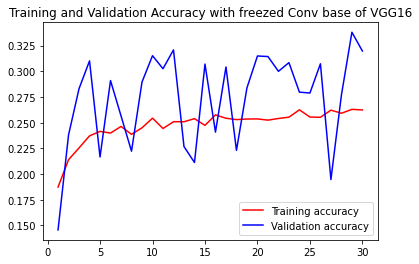

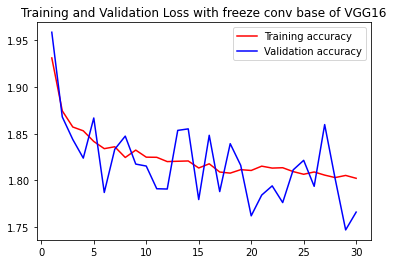

In [57]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title('Training and Validation Accuracy with freezed Conv base of VGG16')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title('Training and Validation Loss with freeze conv base of VGG16')
plt.legend()
plt.show()

In [58]:
print('\nEvaluate on Validation data')
results_validation = model.evaluate_generator(validation_generator, 3589//50 )
print('Validation loss, Validation Accuracy:', results_validation)


Evaluate on Validation data
Instructions for updating:
Please use Model.evaluate, which supports generators.
Validation loss, Validation Accuracy: [1.7658255100250244, 0.3202816843986511]


In [59]:
print('\nEvaluate on test data')
results_test = model.evaluate_generator(test_generator, 3589//50)
print('test loss, test acc:', results_test)


Evaluate on test data
test loss, test acc: [1.7605599164962769, 0.3222535252571106]


In [61]:
EPOCHS = 30
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]

In [62]:
print(epoch_str)
print(test_acc)

-EPOCHS_30
test_acc_0.322


In [69]:
# Saving the history contents
history_path = "drive/My Drive/ENGR635-Deep Learning System Design Project/Models/VGG16/history_VGG16"+epoch_str + test_acc + ".npy"
np.save(history_path, history.history)

In [70]:
# Saving the model
model_path = "drive/My Drive/ENGR635-Deep Learning System Design Project/Models/VGG16/VGG16" + epoch_str + test_acc + '.h5'
model.save(model_path)

### Fine Tuning 

In [71]:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [72]:
conv_base.trainable = True

In [73]:
# Choose the last two convolutional block for fine tuning
# For fine tuning, selecting the last Inception Block training.
set_trainable = False
for layer in model.layers:
  if layer.name == "block5_conv2":
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [74]:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [75]:
EPOCHS = 5
history = model.fit_generator(
    train_generator,
    steps_per_epoch=28709//50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=3589//50,
    shuffle=True,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)

Epoch 1/5
574/574 [==============================] - 353s 615ms/step - loss: 1.8049 - accuracy: 0.2603 - val_loss: 1.8242 - val_accuracy: 0.2569
Epoch 2/5
574/574 [==============================] - 353s 614ms/step - loss: 1.7985 - accuracy: 0.2630 - val_loss: 1.8371 - val_accuracy: 0.2456
Epoch 3/5
574/574 [==============================] - 355s 618ms/step - loss: 1.8094 - accuracy: 0.2627 - val_loss: 1.8671 - val_accuracy: 0.2011
Epoch 4/5
574/574 [==============================] - 349s 609ms/step - loss: 1.8028 - accuracy: 0.2611 - val_loss: 1.7753 - val_accuracy: 0.3287
Epoch 5/5
574/574 [==============================] - 347s 604ms/step - loss: 1.7967 - accuracy: 0.2630 - val_loss: 1.8006 - val_accuracy: 0.2738


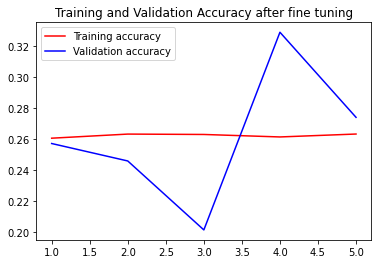

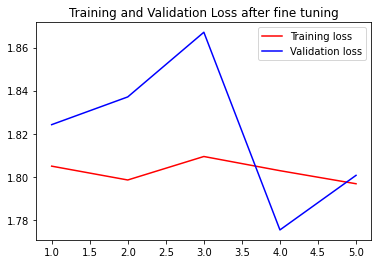

In [76]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title('Training and Validation Accuracy after fine tuning')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title('Training and Validation Loss after fine tuning')
plt.legend()
plt.show()

In [ ]:
print('\nEvaluate on test data')
results_test = model.evaluate_generator(test_generator, 3589//50)
print('test loss, test acc:', results_test)


Evaluate on test data


In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]

In [ ]:
# Saving the history contents
history_path = "drive/My Drive/ENGR635-Deep Learning System Design Project/Models/VGG16/finetune_history_VGG16"+epoch_str + test_acc + ".npy"
np.save(history_path, history.history)

In [ ]:
# Saving the model
model_path = "drive/My Drive/ENGR635-Deep Learning System Design Project/Models/VGG16/VGG16_finetune" + epoch_str + test_acc + '.h5'
model.save(model_path)